In [18]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import xarray as xr
import pandas as pd

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

%matplotlib inline

# List of available time intervals

In [ ]:
bristol_model = pd.read_csv('dataset/bristol_sim_list.csv')
bristol_model

# Visualise the paleo-elevation dataset

### Dataset link

Salles, T., L. Husson, M. Lorcery, B. Halder Boggiani (2022). Paleo-Physiography Elevation-only Dataset, HydroShare, http://www.hydroshare.org/resource/b3f1e3581d174bf58b00ba5672604710

### THREDDS Data Service

https://thredds.hydroshare.org/thredds/catalog/hydroshare/resources/b3f1e3581d174bf58b00ba5672604710/data/contents/catalog.html


Plotting a specific time interval is done by specifying a time 

In [ ]:
time = 145

We then load the netcdf dataset.

In [4]:
url = 'http://thredds.hydroshare.org/thredds/dodsC/hydroshare/resources/b3f1e3581d174bf58b00ba5672604710/data/contents/z'+str(time)+'Ma.nc'
elev_ds = xr.open_dataset(url)
dsz = elev_ds.z.load()
dsz

<xarray.DataArray 'z' (latitude: 3601, longitude: 7201)>
array([[-2972.50830078, -2662.80077966, -2631.93308034, ...,
        -2309.37737583, -2309.40740202, -2309.43549334],
       [-2594.66459045, -2594.37178643, -2594.19522479, ...,
        -2309.40467445, -2309.43483926, -2309.46295884],
       [-2405.33099015, -2486.22169318, -2546.89022017, ...,
        -2309.43412037, -2309.46431742, -2309.49235855],
       ...,
       [-3420.05504904, -3419.21421332, -3458.79600204, ...,
        -4830.33446916, -4830.33154694, -4830.33154502],
       [-3137.4899492 , -3275.61389619, -3383.4257913 , ...,
        -4830.33447119, -4830.3344693 , -4830.3315468 ],
       [-3255.18070911, -3297.45862938, -3363.71791845, ...,
        -4830.33447312, -4830.33447123, -4830.33446944]])
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.95 -89.9 -89.85 ... 89.9 89.95 90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    units:        m
    long_name:    Paleo-elevation under surface processes forcing
    description:  Elevation assuming surface processes (riverine and hillslop...
    _ChunkSizes:  [ 901 1801]

## Global map

For plotting global dataset, we will coarsen the 0.05 degree resolution, by specifying a coarsen factor (e.g. 2,3,4,...)

In [5]:
coarsen_factor = 4
coarsez = dsz.coarsen(longitude=coarsen_factor, 
                      boundary='trim').mean().coarsen(latitude=coarsen_factor, 
                                                      boundary='trim').mean()

Let's make the plot

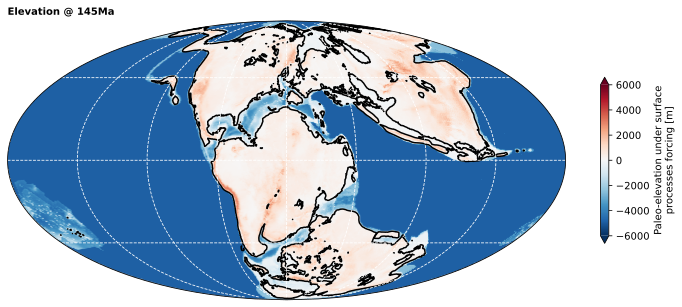

In [6]:
cbar_kwargs = {'orientation':'vertical', 'shrink':0.3}
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(), aspect='auto')
coarsez.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),
                x='longitude', y='latitude',
                robust=True, vmin=-6000, vmax=6000,
                cmap='RdBu_r',
                cbar_kwargs=cbar_kwargs,
                add_colorbar=True,
                extend='both')

ax.gridlines(color='white',linestyle='--', 
             xlocs=np.arange(-180,180,45), ylocs=np.arange(-90,90,45))

cnplot = ax.contour(coarsez.longitude, coarsez.latitude, coarsez,
                        linewidths=1.5,
                        colors='k',
                        levels=1, 
                        transform=ccrs.PlateCarree())

ax.set_title('Elevation @ '+str(time)+'Ma', fontsize=10, fontweight="bold", loc='left')
plt.tight_layout()
plt.show()

## Local map

For a local plot, we will use a higher resolution and slice the dataset to the region of interest:

In [41]:
coarsen_factor = 1
midz = dsz.coarsen(longitude=coarsen_factor, 
                      boundary='trim').mean().coarsen(latitude=coarsen_factor, 
                                                      boundary='trim').mean()

In [42]:
min_lon = -20    # lower left longitude
min_lat = -30    # lower left latitude
max_lon = 0     # upper right longitude
max_lat = -10     # upper right latitude

# Defining region boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
dsz_clip = midz.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

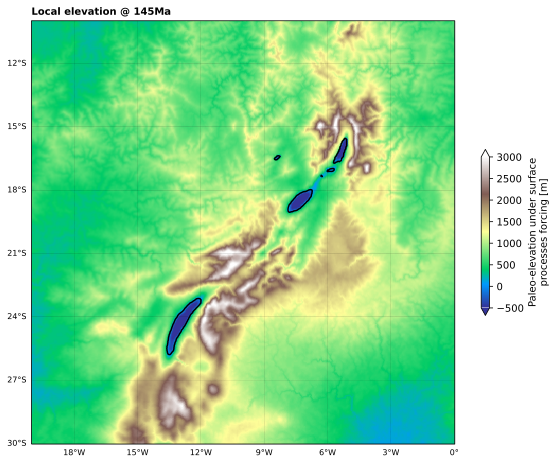

In [55]:
cbar_kwargs = {'orientation':'vertical', 'shrink':0.3}
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
dsz_clip.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),
                x='longitude', y='latitude',
                robust=True, vmin=-500, vmax=3000,
                cmap='terrain',
                cbar_kwargs=cbar_kwargs,
                add_colorbar=True,
                extend='both')

cnplot = ax.contour(dsz_clip.longitude, dsz_clip.latitude, dsz_clip,
                        linewidths=1.5,
                        colors='k',
                        levels=[0], 
                        transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

ax.set_title('Local elevation @ '+str(time)+'Ma', fontsize=10, fontweight="bold", loc='left')
plt.tight_layout()
plt.show()